# Recommender using MySQL Database / frequency of the chords

### This analysis focuses more on the frequency of the chords within a song
Meaning that probably songs that use more or less the same amount of chords will be clustered this can be confirmed with the bar plots

In [180]:
from ipynb.fs.full.DBMySQLConnection import getDB, connectDB
from ipynb.fs.full.Utils import listKeys
import pandas as pd
import plotly.express as px
import dask_ml.cluster
import copy
import math 
from ipynb.fs.full.Utils import loadDataFrames, spotifyKeys

In [209]:
def barPlotByCategory(category):
    cat = chordsDF[chordsDF['category'] == category].iloc[:,0:-1]
    catSum = cat.sum(axis=0)
    cat = pd.DataFrame({'chords':catSum.index, 'count':catSum.values})
    fig = px.bar(cat, x='chords', y='count', title='Count of chords per category on :' + str(category) )
    fig.show()
    
def createRatiosPerCategory(chord):
    chordsGroupedCat = chordsDF[[chord, 'category']].groupby(['category']).sum()
    totalGroupedChords = chordsGroupedCat[chord].sum()
    chordsRatioCat = chordsGroupedCat[chord]/totalGroupedChords.sum()
    return chordsRatioCat.values.tolist()

def plotChordsPerCategory(numClusters):
    for k in range(0, numClusters):
        barPlotByCategory(k)
        
def getClustersChordsRatios(listKeys):
    chordsRatio = pd.DataFrame(columns = listKeys)
    for key in listKeys:
        chordsRatio[key] = createRatiosPerCategory(key)
    chordsRatio['cluster'] = chordsRatio.index
    chordsRatioCluster  = chordsRatio.copy(deep=True)
    chordsRatio = chordsRatio.melt(id_vars=["cluster"], 
        var_name="chord", 
        value_name="ratio")
    return chordsRatio, chordsRatioCluster

def getRatioChordsSong(newSongChords):
    newSongTotalChords = sum(newSongChords)
    return list(map(lambda x: x/newSongTotalChords, newSongChords))

def distance(x,y):
    dist = 0.0
    for i, elem in enumerate(x):
        dist+= (elem-y[i])*(elem-y[i])
    return math.sqrt(dist)

def closest_clusters(song):
    distances = []
    newSongRatio = getRatioChordsSong(song)
    for k in range(0,numClusters):
        clusterChordRatios = chordsRatio[chordsRatio['cluster'] == k].iloc[:, 0:-1].values[0].tolist()
        dist = distance(clusterChordRatios,newSongRatio)
        distances.append((k, dist))
    distances.sort(key = lambda x: x[1])
    return distances

def plotChords(chordsDF, titleLabel='Histogra'):    
    cat = pd.DataFrame({'chords':chordsDF.sum().index.tolist(), 'count':chordsDF.sum().values.tolist()})
    fig = px.bar(cat, x='chords', y='count', title=titleLabel, template='plotly_white')
#     fig = px.bar(cat, x='chords', y='count', title=titleLabel, marker = [color = 'green')
    

    fig.show()
    
# def mapChordsToKeys(songChords):
#     keys = {}

#     for c in songChords:
#         for symbol in c.split(','):
#             if symbol not in keys: 
#                 keys[symbol] = 1
#             else:
#                 keys[symbol] += 1
#     return keys

def createEmptyListKeysDF():
    chordsDF = pd.DataFrame(columns = listKeys)
    return chordsDF

def createEmptyKeyMapper():
    keyMapper = {}
    for key in listKeys:
        if key not in keyMapper:
            keyMapper[key] = 0  
    return keyMapper

def createDFCountChordsPerSong(df):
    keyMapper = createEmptyKeyMapper()
    chordsDF = createEmptyListKeysDF()
    keyMapper['id'] = 0
    ## Going through all songs and mapping its chrods in C major to the table frame 

    for key in range(len(df)):
        c = df.iloc[key, :].chords
        id = df.iloc[key, :].id
        keyMapperCopy = copy.deepcopy(keyMapper)

        for symbol in c.split(','):
            keyMapperCopy[symbol] += 1
        

        keyMapperCopy['id'] = id
        chordsDF = chordsDF.append(keyMapperCopy, ignore_index=True)
    
    
    # Formatting chords dataframe
    chordsDF = chordsDF.sort_values('id')
    chordsDF.id = chordsDF.id.astype('int64')
    chordsDF = chordsDF.set_index('id')
    return chordsDF

In [182]:
# Regardless of the DB Engine fill df variable

cn = connectDB()
df = pd.read_sql("""
select c.id, c.song, c.artist,c.tonality, c.capo, cc.orig_key, cc.chords
from chords as c
inner join clean_chords as cc
        on c.id = cc.id
where c.id_track is not null
""", con=cn)
cn.close()

### Checking list of chords

In [183]:
df.head(5)

,id,song,artist,tonality,capo,orig_key,chords
0,23,Beer Drinkers And Hell Raisers,ZZ Top,,0,E,"Cm,C,A#,F,F,G,G,Cm,Cm,C,A#,F,F,F,F,Cm,G,G,G,G,..."
1,73,Harvest Moon,Neil Young,,0,G,"C,F,F,C,F,C,F,F,C,F,C,F,F,C,F,C,F,C,C,Em,F,Dm,..."
2,105,Ball And Chain,XTC,,0,C,"C,C,C,C,C,C,A#,F,C,G,D,F,C,G,D,F,C,G,D,F,C,G,D..."
3,118,Los Angeles,X,,0,G,"A,F,G,C,D,D,C,G,F,D,C,G,F,D,C,F,D,C,F,D,C,F,D,..."
4,120,The Hungry Wolf,X,,0,E,"G#,G,G,G#,G,G#,G,A#,C,G#,G,G#,G,G#,G,A#,C,C,G#..."


In [184]:
chordsDF = createDFCountChordsPerSong(df)
len(chordsDF)

4753

In [185]:
## Bringing Dataframes
spotifyFeatures, transitionMatrices, df = loadDataFrames()

In [186]:
## Merging spotify information with chords
spChords = spotifyFeatures.merge(chordsDF, left_index=True, right_index=True)

In [187]:
# Getting final list of songs
chordsDF = spChords[listKeys]
# Exluding the id chord
onlyChords = chordsDF.iloc[:,0:-1]

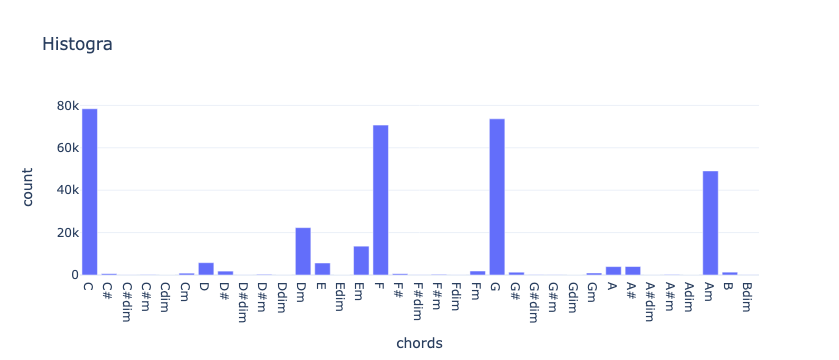

In [210]:
plotChords(onlyChords)

In [189]:
# Merges listKeys columsn with key and mode columns
keyModecolumns = ['key', 'mode']
keyModecolumns.extend(listKeys)
keyModeChords = spChords[keyModecolumns]

In [190]:
major = keyModeChords.loc[keyModeChords['mode'] == 1]
minor = keyModeChords.loc[keyModeChords['mode'] == 0]

#Excluding Key and Mode columns
major = major.iloc[:, 2:]
minor = minor.iloc[:, 2:]

### Plotting Major and Minor Chords

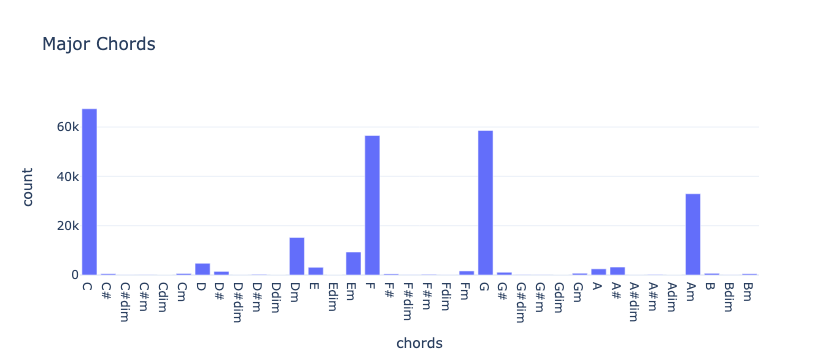

In [211]:
plotChords(major, 'Major Chords')

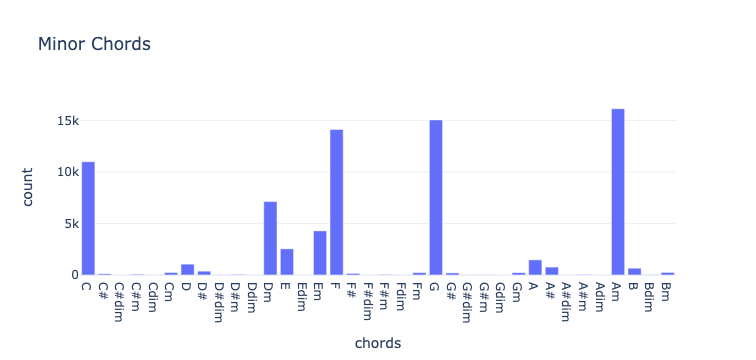

In [192]:
plotChords(minor,'Minor Chords')

### Distribution of chords using key


In [193]:
keyModeChords.iloc[:, 1:]

,mode,C,C#,C#dim,C#m,Cdim,Cm,D,D#,D#dim,...,Gm,A,A#,A#dim,A#m,Adim,Am,B,Bdim,Bm
id,,,,,,,,,,,,,,,,,,,,,
23,1,2,0,0,0,0,5,0,0,0,...,0,0,2,0,0,0,0,0,0,0
105,1,11,0,0,0,0,0,5,0,0,...,0,0,1,0,0,0,0,0,0,0
118,1,19,0,0,0,0,0,21,6,0,...,0,8,0,0,0,0,0,0,0,0
120,0,6,0,0,0,0,0,0,1,0,...,0,0,3,0,0,0,0,0,0,0
234,1,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3781055,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,25,0,0,0
3860363,1,20,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,0,0,0
3898172,1,14,0,0,0,0,0,0,0,0,...,0,0,14,0,0,0,0,0,0,0


### Distribution of songs by key

In [196]:
spotifyKeys

['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

In [197]:
keyChords = keyModeChords.drop('mode', inplace=False, axis=1)
keyModeChords.key = keyModeChords.key.apply(lambda x: spotifyKeys[x])

/usr/local/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [200]:
keyModeChords 

,key,mode,C,C#,C#dim,C#m,Cdim,Cm,D,D#,...,Gm,A,A#,A#dim,A#m,Adim,Am,B,Bdim,Bm
id,,,,,,,,,,,,,,,,,,,,,
23,G,1,2,0,0,0,0,5,0,0,...,0,0,2,0,0,0,0,0,0,0
105,G,1,11,0,0,0,0,0,5,0,...,0,0,1,0,0,0,0,0,0,0
118,D,1,19,0,0,0,0,0,21,6,...,0,8,0,0,0,0,0,0,0,0
120,B,0,6,0,0,0,0,0,0,1,...,0,0,3,0,0,0,0,0,0,0
234,D#,1,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3781055,C#,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,25,0,0,0
3860363,A#,1,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,0,0,0
3898172,F#,1,14,0,0,0,0,0,0,0,...,0,0,14,0,0,0,0,0,0,0


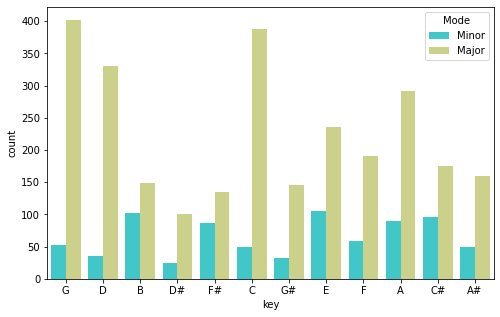

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns




plt.figure(figsize=(8,5))
g = sns.countplot(x='key',data=keyModeChords, palette='rainbow',hue='mode')
plt.legend(title='Mode', loc='upper right', labels=['Minor', 'Major'])
plt.show(g)

In [ ]:
len(chordsSum.values.tolist())

In [ ]:
chordsSum.columns

In [ ]:
X = chordsDF.values.tolist()

## Applying K-means Clustering
Inspired from [this article](https://medium.com/towards-data-science/k-means-clustering-unsupervised-learning-for-recommender-systems-397d3790f90f)

In [474]:
numClusters = 15

km = dask_ml.cluster.KMeans(n_clusters=numClusters)
km.fit(X)

KMeans(n_clusters=15)

In [475]:
## Concatenating the labels into the dataset 
labels = list(km.labels_.compute())
chordsDF['category'] = labels

In [476]:
chordsDF.head(2)

,C,C#,C#dim,C#m,Cdim,Cm,D,D#,D#dim,D#m,...,A,A#,A#dim,A#m,Adim,Am,B,Bdim,Bm,category
0,2,0,0,0,0,5,0,0,0,0,...,0,2,0,0,0,0,0,0,0,1
1,66,0,0,0,0,7,40,27,0,0,...,4,28,0,0,0,39,0,0,24,6


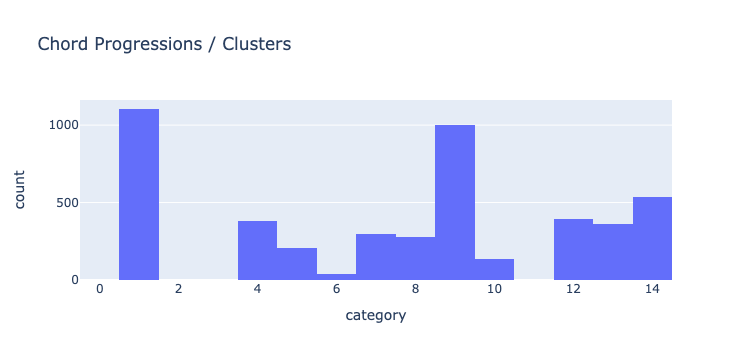

In [477]:
fig = px.histogram(chordsDF, x="category", title='Chord Progressions / Clusters')
fig.show()

### Doing some quick analysis

most popular chords among categories

In [85]:
plotChordsPerCategory(numClusters)

NameError: name 'numClusters' is not defined

### Ratio per chords and category


In [479]:
### Example , what's the ratio of the chord C per category
clusterChordsRatio, chordsRatio = getClustersChordsRatios(listKeys)

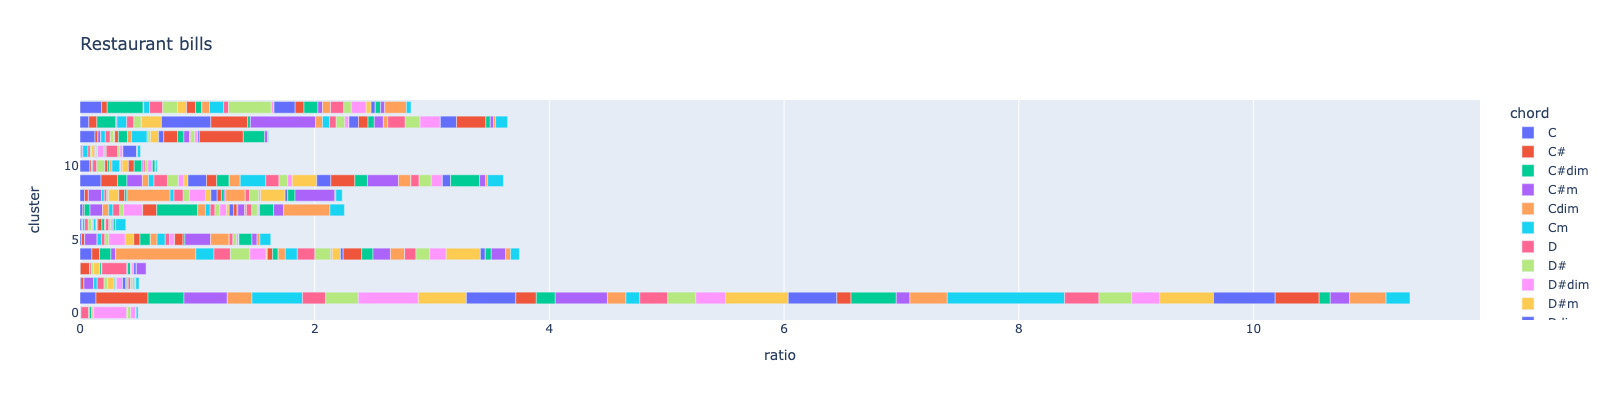

In [480]:
fig = px.bar(clusterChordsRatio, x="ratio", y="cluster", color='chord', orientation='h',
             height=400,
             title='Restaurant bills')
fig.show()

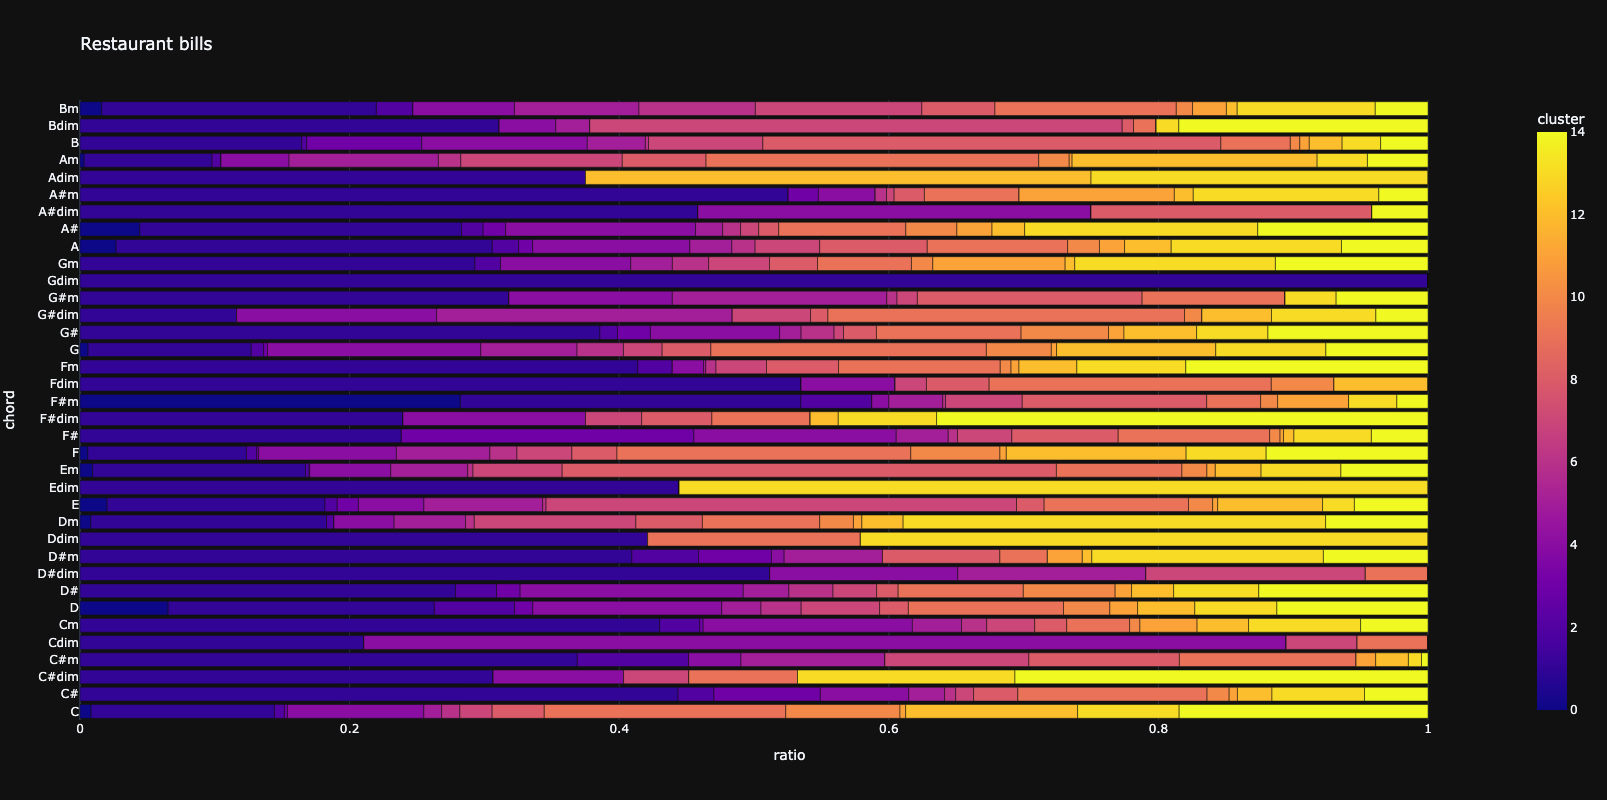

In [481]:
fig = px.bar(clusterChordsRatio, x="ratio", y="chord", color='cluster', orientation='h',
             height=800,
             template='plotly_dark',
             title='Restaurant bills')
fig.show()

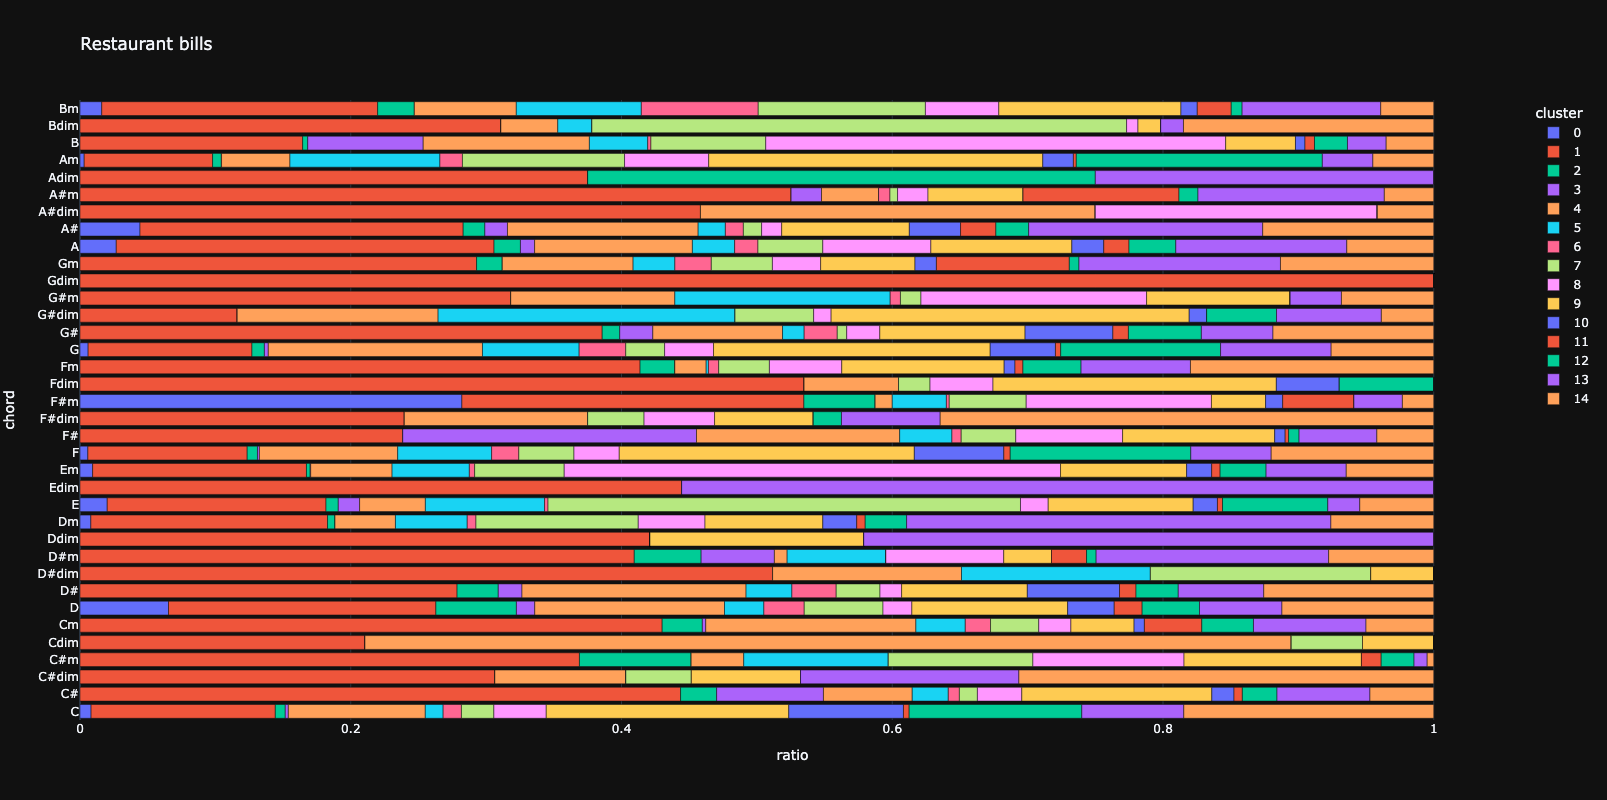

In [482]:
clusterChordsRatio['cluster'] = clusterChordsRatio['cluster'].astype(str)
fig = px.bar(clusterChordsRatio, x="ratio", y="chord", color='cluster', orientation='h',
             height=800,
             template='plotly_dark',
             title='Restaurant bills')
fig.show()

## Using Euclidean distance to make recommendations

### what songs are close to coldplay's don't panic

In [511]:


# df[df['song']=='Dont Panic'] ---- 163

coldplaySong = chordsDF.filter(items = [163], axis=0).iloc[:,0:-1].values.tolist()[0]
closest_clusters(coldplaySong)

[(10, 0.4116053949613803),
 (6, 0.47043322361816636),
 (12, 0.478586741255917),
 (2, 0.49791451176831864),
 (11, 0.5137852277562857),
 (5, 0.5232989753086791),
 (3, 0.5517588488324034),
 (0, 0.5628589972618132),
 (9, 0.6092232978545252),
 (14, 0.7038972353533323),
 (7, 0.7107148621565298),
 (8, 0.7416296592520742),
 (13, 0.9626552693589769),
 (4, 0.9740014788112132),
 (1, 2.149682562142517)]

In [520]:
chordsDF[chordsDF['category'] == 10]


,C,C#,C#dim,C#m,Cdim,Cm,D,D#,D#dim,D#m,...,A,A#,A#dim,A#m,Adim,Am,B,Bdim,Bm,category
15,76,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,6,0,0,0,10
19,54,0,0,0,0,0,0,0,0,0,...,8,0,0,0,0,15,0,0,0,10
29,43,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,10
43,156,0,0,0,0,0,6,0,0,0,...,0,0,0,0,0,0,0,0,0,10
51,66,0,0,0,0,0,6,0,0,0,...,0,0,0,0,0,0,0,0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4367,84,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,25,0,0,0,10
4376,60,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,14,0,0,0,10
4487,58,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,20,0,0,0,10
4555,52,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,16,0,0,0,10


,id,song,artist,tonality,capo,orig_key,chords
19,816,Beautiful Day,U2,,0,D,"G,Am,C,F,C,G,G,Am,C,F,C,G,G,Am,C,F,C,G,G,Am,C,..."


In [526]:
df.filter(items = [19], axis=0)

,id,song,artist,tonality,capo,orig_key,chords
19,816,Beautiful Day,U2,,0,D,"G,Am,C,F,C,G,G,Am,C,F,C,G,G,Am,C,F,C,G,G,Am,C,..."


In [528]:
u2beautiful = chordsDF.filter(items = [19], axis=0).iloc[:,0:-1].values.tolist()[0]

In [529]:
getRatioChordsSong(u2beautiful)

[0.32727272727272727,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.024242424242424242,
 0.0,
 0.0,
 0.024242424242424242,
 0.18181818181818182,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.30303030303030304,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.048484848484848485,
 0.0,
 0.0,
 0.0,
 0.0,
 0.09090909090909091,
 0.0,
 0.0,
 0.0]

In [531]:
getRatioChordsSong(coldplaySong)

[0.21739130434782608,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.13043478260869565,
 0.0,
 0.0,
 0.0,
 0.30434782608695654,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.06521739130434782,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2826086956521739,
 0.0,
 0.0,
 0.0]